<a href="https://colab.research.google.com/github/jquinnlee/MAIN_2022_calRSA/blob/main/MAIN2022_calciumRSA_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title **Download data from Dropbox (run at start of new session)**
# download data from dropbox folder as a zip file
!curl -L https://www.dropbox.com/sh/kc839i4qtxct4vg/AACOQ-UDwlrMen1Gg7WDcT0oa?dl=0 > data.zip
# unzip file
!unzip ./data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   134    0   134    0     0    260      0 --:--:-- --:--:-- --:--:--   260
100   276  100   276    0     0    169      0  0:00:01  0:00:01 --:--:--  2486
100 8549M  100 8549M    0     0  84.9M      0  0:01:40  0:01:40 --:--:-- 59.3M
Archive:  ./data.zip
mapname:  conversion of  failed
replace QLAK-CA1-50? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace QLAK-CA1-50_SHR_pvals? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [3]:
#@title **Import required python libraries**
# required libraries
from glob import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.ndimage import gaussian_filter, gaussian_filter1d
import joblib
from copy import deepcopy
import torch
from scipy.stats import pearsonr
from sklearn.manifold import MDS
import matplotlib.path as mpath
import matplotlib.patches as patches
import matplotlib as mpl
import scipy.stats as stats
import pandas as pd

In [2]:
#@title **Define helper functions**

def load_dat(animal, p='/content'):
    print(f'Loading preprocessed data for animal {animal}')
    return joblib.load(os.path.join(p, animal))


def plot_traces_position(data, animal, examples_days,
                         n_frames_incl=int(30 * 60 * 1)):
  for day in example_days:
    sns.set(style='dark')
    plt.figure(figsize=(20, 7))
    ax = plt.subplot(211)
    ax.plot(data[animal]['position'][day][0, :n_frames_incl], linewidth=2.5)
    ax.plot(data[animal]['position'][day][1, :n_frames_incl], linewidth=2.5)
    ax.set_xticks([])
    ax.set_yticks(np.arange(25, 76, 25))
    ax.set_xlim([0, n_frames_incl])
    ax.set_ylim([0, 75])
    ax.set_ylabel('Head position (cm)')
    plt.legend(['x position', 'y position'], loc='upper left')
    ax = plt.subplot(212)
    cell_idx = np.any(~np.isnan(data[animal]['trace'][day]), axis=1)
    mappable = ax.imshow(data[animal]['trace'][day][cell_idx, :n_frames_incl],
                        cmap='binary', origin='lower')
    ax.set_aspect(.5e4*(75/n_frames_incl)/cell_idx.sum())
    ax.set_xlabel('Time (30 Hz)')
    ax.set_ylabel('Neuron')
    plt.subplots_adjust(hspace=0)
    plt.suptitle(f'Day {day+1}\n(first {n_frames_incl} frames)')
    plt.show()


def plot_example_maps(cell_idx, example_maps, example_frs, num_examples=10):
  for cell in cell_idx[:num_examples]:
    plt.figure(figsize=(6,30))
    ax1, ax2, ax3, ax4 = plt.subplot(141), plt.subplot(142), plt.subplot(143), \
      plt.subplot(144)
    ax1.imshow(example_maps[:, :, cell, 0], cmap='jet')
    ax1.set_xticks([])
    ax1.set_xlabel(f'{example_frs[0, cell]:.2f} Hz')
    ax1.set_yticks([])
    ax1.set_title('day 1', weight='bold')
    ax1.set_ylabel(f'neuron {cell}', weight='bold')
    ax2.imshow(example_maps[:, :, cell, 1], cmap='jet')
    ax2.set_xticks([])
    ax2.set_xlabel(f'{example_frs[1, cell]:.2f} Hz')
    ax2.set_yticks([])
    ax2.set_title('day 11', weight='bold')
    ax3.imshow(example_maps[:, :, cell, 2], cmap='jet')
    ax3.set_xticks([])
    ax3.set_xlabel(f'{example_frs[2, cell]:.2f} Hz')
    ax3.set_yticks([])
    ax3.set_title('day 21', weight='bold')
    mappable = ax4.imshow(example_maps[:, :, cell, 3], cmap='jet')
    ax4.set_xticks([])
    ax4.set_xlabel(f'{example_frs[3, cell]:.2f} Hz')
    ax4.set_yticks([])
    ax4.set_title('day 31', weight='bold')
    plt.show()


def get_environment_label(env_name):
    '''
    get_environment label will return a custom maker from environment name as input that can be used for plotting
    '''
    # First draw vertices that will create the shape of the environment based on input name (env names in weirdGeos dat)
    if env_name == 'square':
        polys = np.array([[0, 0], [0, 30], [30, 30], [30, 0], [0, 0]])-15
    elif env_name == 'o':
        polys = np.array([[0, 0], [0, 30], [21, 30], [21, 21], [10, 21], [10, 10], [21, 10], [21, 30], [30, 30],
                          [30, 0], [0, 0]])-15
    elif env_name == 't':
        polys = np.array([[0, 10], [21, 10], [21, 0], [30, 0], [30, 30], [21, 30], [21, 21], [0, 21]])-15
    elif env_name == 'u':
        polys = np.array([[0, 0], [0, 30], [10, 30], [10, 10], [20, 10], [20, 30], [30, 30], [30, 0], [0, 0]]) -15
    elif env_name == 'rectangle':
        polys = np.array([[0, 10], [0, 30], [30, 30], [30, 10], [0, 10]]) - 15
    elif env_name == '+':
        polys = np.array([[0, 10], [10, 10], [10, 0], [21, 0], [21, 10], [30, 10], [30, 21], [21, 21], [21, 30],
                          [10, 30], [10, 21], [0, 21], [0, 10]]) - 15
    elif env_name == 'i':
        polys = np.array([[0, 0], [10, 0], [10, 10], [21, 10], [21, 0], [30, 0], [30, 30], [21, 30], [21, 21],
                          [10, 21], [10, 30], [0, 30], [0, 0]]) - 15
    elif env_name == 'l':
        polys = np.array([[0, 0], [0, 30], [10, 30], [10, 10], [30, 10], [30, 0], [0, 0]]) - 15
    elif env_name == 'bit donut':
        polys = np.array([[0, 0], [0, 30], [21, 30], [21, 21], [10, 21], [10, 10], [21, 10], [21, 30], [30, 30],
                          [30, 10], [21, 10], [21, 0], [0, 0]]) - 15
    elif env_name == 'glenn':
        polys = np.array([[0, 10], [0, 30], [21, 30], [21, 21], [30, 21], [30, 0], [10, 0], [10, 10], [0, 10]]) - 15

    # Use Path function to create image path that matplotlib can use for plotting with
    return mpath.Path(polys), polys


def plot_rsm_mds(rsm, metric=True):
    envs = rsm['envs']
    animal = rsm['animal']
    sns.set(style='dark', font_scale=1.25)
    plt.figure(figsize=(22, 12))
    target_rsms = [deepcopy(rsm['firing_rate']),
                   deepcopy(rsm['rate_map']),
                   deepcopy(rsm['trace'])]
    env_markers = [get_environment_label(env)[0] for env in envs]
    env_polys = [get_environment_label(env)[1] for env in envs]
    for i, target_rsm in enumerate(target_rsms):
        np.random.seed(2022)
        # embed components in 2d w MDS
        if metric:
            MDS_model = MDS(n_components=2, metric=True, dissimilarity='precomputed',
                            eps=1e-10, max_iter=1000, n_init=100, n_jobs=6)
        else:
            MDS_model = MDS(n_components=2, metric=False, dissimilarity='precomputed',
                            eps=1e-10, max_iter=1000, n_init=100, n_jobs=6)
        embeddings = MDS_model.fit_transform(1 - target_rsm)
        cmap = mpl.cm.get_cmap('viridis')
        ax = plt.subplot(2, 3, i + 4)
        # plot the lines for each shape to be connected
        for j in range(embeddings.shape[0]):
            ax.scatter(embeddings[j, 0], embeddings[j, 1], s=150, marker=env_markers[j], alpha=1,
                       color=cmap(j/embeddings.shape[0]))

        for env in envs[:11]:
            ax.plot(embeddings[np.where(envs == env)[0], 0],
                    embeddings[np.where(envs == env)[0], 1],
                    alpha=.6, linewidth=1.5, linestyle=':', color='k')
        ax.set_xlabel('MDS Dim 1 (abu)')
        ax.set_ylabel('MDS Dim 2 (abu)')
        cent = np.mean(embeddings, axis=0)
        minmax = np.amax(embeddings) - np.amin(embeddings)
        ax.set_xlim([cent[0] - .7 * minmax, cent[0] + .7 * minmax])
        ax.set_xticks(np.linspace(-1, 1, 5))
        ax.set_yticks(np.linspace(-1, 1, 5))
        ax.set_ylim([cent[1] - .7 * minmax, cent[1] + .7 * minmax])
        ax.set_aspect('equal')
        ax.set_title(f'stress: {MDS_model.stress_:.3f}', fontdict={'size': 12})

        # plot each rsm on every other subplot (vertical)
        # first plot average rate map correlation
        ax = plt.subplot(2, 3, i + 1)
        temp_target_rsm = deepcopy(target_rsm)
        temp_target_rsm[np.eye(temp_target_rsm.shape[0]).astype(bool)] = np.nan
        mappable = ax.imshow(temp_target_rsm, vmin=0, vmax=.65, cmap='inferno')
        cbar = plt.colorbar(mappable, shrink=1)
        cbar.ax.set_title('R')
        ax.set_xticks(np.arange(len(env_polys)))
        ax.set_xticklabels([])
        ax.set_yticks(np.arange(len(env_polys)))
        ax.set_yticklabels([])
        tick_labels = ax.xaxis.get_ticklabels()
        # shape tick params for plotting
        tickypos = 31.5
        tickxpos = -2.
        label_scale = .023
        for j, tick in enumerate(tick_labels):
            ax.add_patch(patches.PathPatch(mpath.Path(env_polys[j] * label_scale + np.array([j, tickypos])),
                                           clip_on=False, facecolor='b', edgecolor='b'))
            ax.add_patch(patches.PathPatch(mpath.Path(env_polys[j] * label_scale + np.array([tickxpos, j])),
                                           clip_on=False, facecolor='b', edgecolor='b'))
        if i == 0:
            ax.set_title(f'{animal}\nFiring rate correlation',
                         fontdict={'weight': 'semibold', 'size': 16})
        elif i == 1:
            ax.set_title(f'{animal}\nRate map correlation',
                         fontdict={'weight': 'semibold', 'size': 16})
        elif i == 2:
            ax.set_title(f'{animal}\nTrace co-activity',
                         fontdict={'weight': 'semibold', 'size': 16})
    plt.subplots_adjust(hspace=.4, wspace=.1)
    plt.show()

In [4]:
# load data to python dictionary
animal = 'QLAK-CA1-50'
data = load_dat(animal)
# delete SFPs to save memory
del data[animal]['SFPs'], data[animal]['SFPs_traced'] 

Loading preprocessed data for animal QLAK-CA1-50


In [6]:
# Print out the dimensions of data and to what each dimension correspond

print('\nCalcium trace data have dimensions days, cells, frames: {}\n'.format(
    data[animal]['trace'].shape))

'''
Complete fields below to print out position and rate map data shape
based on example above (answers are provided below if needed).
'''

print('Position data have dimensions days, x-y position, frames: {}\n'.format(
    data[][].shape))

print('Rate maps have dimensions x-bins, y-bins, cells, days: {}\n'.format(
    data[][][].shape))

In [5]:
#@title ####*Answers*
# print('\nCalcium trace data have dimensions days, cells, frames: {}\n'.format(
#     data[animal]['trace'].shape))
# print('Position data have dimensions days, x-y position, frames: {}\n'.format(
#     data[animal]['position'].shape))
# print('Rate maps have dimensions x-bins, y-bins, cells, days: {}\n'.format(
#     data[animal]['maps']['smoothed'].shape))

### **Plot position and trace data from the first minutes of some sessions**

In [ ]:
# plot example trace and position data data from first 2 minutes of square days

'''
***
Indicate square days in "example_days" as tuple
***
'''

example_days = ()
plot_traces_position(data, animal, example_days)

In [ ]:
# Calculate average firing rate of all cells on each day
fps = 30

mean_firing_rates = np.zeros(data[animal]['trace'].shape[:2])
for day, traces in enumerate(data[animal]['trace']):
  
  '''
  ***
  Calculate average firing rate from trace data on each day across target axis.
  ***
  '''
  
  mean_firing_rates[day] = 

In [9]:
#@title #### *answers*
# # Calculate average firing rate of all cells on each day
# fps = 30

# mean_firing_rates = np.zeros(data[animal]['trace'].shape[:2])
# for day, traces in enumerate(data[animal]['trace']):
#   '''
#   Calculate average of trace data on each day across target axis.
#   '''
#   mean_firing_rates[day] = np.mean(traces, axis=1) * fps

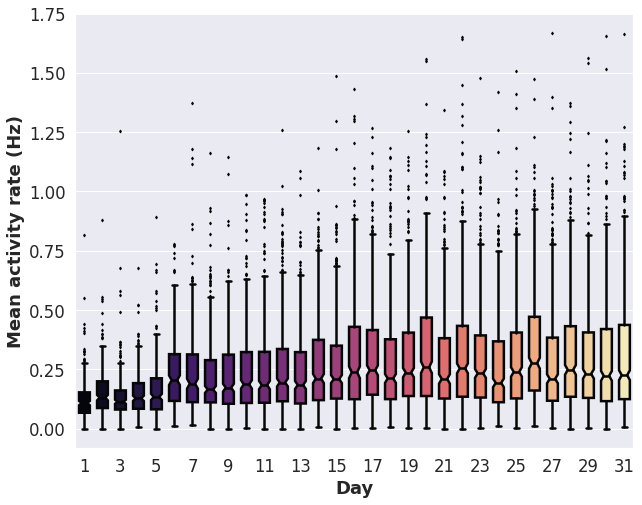

In [10]:
# Visualize the distribution of mean firing rates across sessions
sns.set(style='darkgrid', font_scale=1.5)
plt.figure(figsize=(10,8))
ax = plt.subplot()
sns.boxplot(data=mean_firing_rates.T, linewidth=2.5, width=.6, fliersize=2,
            notch=True, palette='magma')
ax.set_xticks(np.arange(0, mean_firing_rates.shape[0], 2))
ax.set_xticklabels(np.arange(1, mean_firing_rates.shape[0] + 1, 2))
ax.set_ylabel('Mean activity rate (Hz)', weight='bold')
ax.set_xlabel('Day', weight='bold')
plt.show()

In [10]:
# Calculate split-half change in average firing rate of all cells on each day

mean_firing_sh = np.zeros(data[animal]['trace'].shape[:2])
len_recording = data[animal]['trace'].shape[2]

for day, traces in enumerate(data[animal]['trace']):

  '''
  ***
  Calculate the percent split-half change in mean firing rate.
  ***
  '''

  fr_h1, fr_h2 = traces[:, :len_recording//2].mean(axis=1), \
    traces[:, len_recording//2:].mean(axis=1)

  fr_hmax = np.amax(np.vstack((fr_h1, fr_h2)), axis=0)

  mean_firing_sh[day] = 100 * (fr_h1 - fr_h2) / fr_hmax

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


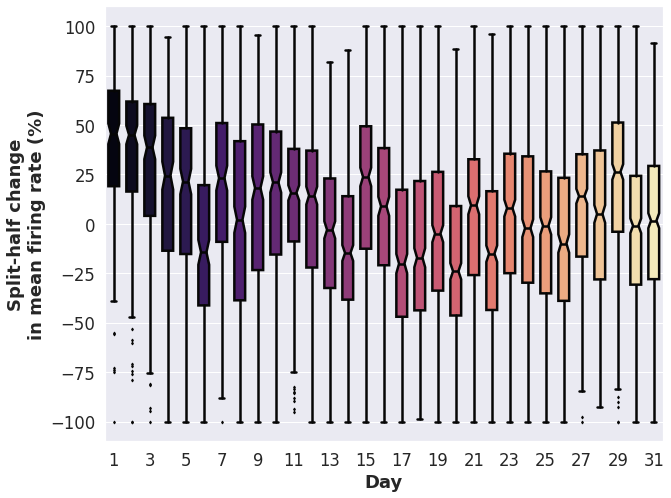

In [11]:
sns.set(style='darkgrid', font_scale=1.5)
plt.figure(figsize=(10,8))
ax = plt.subplot()
sns.boxplot(data=mean_firing_sh.T, linewidth=2.5, width=.6, fliersize=2,
            notch=True, palette='magma')
ax.set_xticks(np.arange(0, mean_firing_sh.shape[0], 2))
ax.set_xticklabels(np.arange(1, mean_firing_sh.shape[0] + 1, 2))
ax.set_ylabel('Split-half change\nin mean firing rate (%)',
              weight='bold')
ax.set_xlabel('Day', weight='bold')
plt.show()

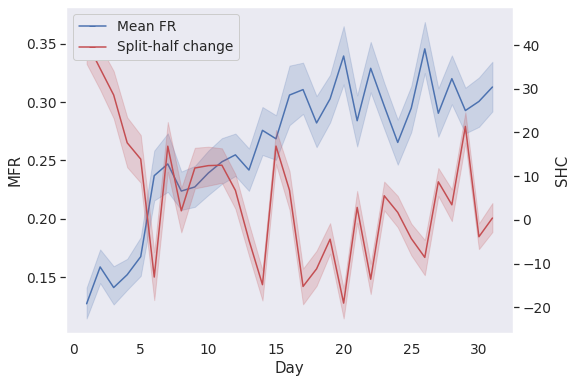

In [12]:
#@title #### Make lineplot with both results on a single graph
df_fr = pd.DataFrame(data=np.zeros([mean_firing_sh.ravel().shape[0], 3]),
                     columns=['Day', 'MFR', 'SHC'])
count = 0
for day in range(mean_firing_sh.shape[0]):
  for cell in range(mean_firing_sh.shape[1]):
    df_fr.iloc[count] = pd.Series(np.hstack((day+1,
                                             mean_firing_rates[day, cell],
                                             mean_firing_sh[day, cell])))
    count += 1
df_fr.dropna(axis=0, inplace=True)

from matplotlib.lines import Line2D
sns.set(style='dark', font_scale=1.25)
plt.figure(figsize=(8,6))
ax = sns.lineplot(data=df_fr, x="Day", y="MFR", legend=False)
ax2 = ax.twinx()
sns.lineplot(data=df_fr, x="Day",
             y="SHC",
             ax = ax2, legend=False, color='r')
plt.legend(handles=[Line2D([], [], marker='_', color="b", label='Mean FR'),
                   Line2D([], [], marker='_', color="r", label='Split-half change')],
          framealpha=1., loc='upper left')
plt.show()

### (Optional) Load computed spatial reliability measures for detecting place cells

In [ ]:
# load spatial reliability p values for all cells
'''
***
load in p values from split-half spatial reliability measure
(take a look at files loaded into 'content' folder)
***
'''
p_vals = joblib.load()

In [ ]:
#@title ####*answer*
# load spatial reliability p values for all cells
p_vals = joblib.load(f'{animal}_SHR_pvals')

### **Plot some example rate maps from repeating squares**

In [ ]:
# grab the rate maps of square days (1, 11, 21, and 31)
example_maps = deepcopy(data[animal]['maps']['smoothed'][:, :, :, example_days])
example_frs = deepcopy(mean_firing_rates[example_days, :])
# determine which cells are registered on every square day
cell_idx = np.where(~np.isnan(example_frs.sum(0)))[0]

In [ ]:
# plot the first 10 example cells
num_example_cells = 10
plot_example_maps(cell_idx, example_maps, example_frs, num_example_cells)

### **Calculate average firing rate correlations, spatial rate map correlations, and trace correlations across all days**

In [ ]:
# Cross-correlate firing rates of registered cells across all days
n_days = mean_firing_rates.shape[0]
# Initialize the rsm, which have the shape (n_days, n_days)
mean_fr_rsm = np.zeros([n_days, n_days])
# Iterate through all pairs of days
for d1, fr1 in enumerate(mean_firing_rates):
  for d2, fr2 in enumerate(mean_firing_rates):
    # Mask out cells that are not registered on both target days

    '''
    ***
    Create boolean mask to determine which cells are registered on both days.
    ***
    '''

    reg_mask = 

    '''
    ***
    Calculate the pearson correlation of firing rates between all cells
    registered on the pair of target days
    ***
    '''
    
    mean_fr_rsm[d1, d2] = 

In [ ]:
#@title ####*answers*
# # Cross-correlate firing rates of registered cells across all days
# n_days = mean_firing_rates.shape[0]
# # Initialize the rsm, which have the shape (n_days, n_days)
# mean_fr_rsm = np.zeros([n_days, n_days])
# # Iterate through all pairs of days
# for d1, fr1 in enumerate(mean_firing_rates):
#   for d2, fr2 in enumerate(mean_firing_rates):
#     # Mask out cells that are not registered on both target days
#     reg_mask = ~np.isnan(fr1 + fr2)
#     # Calculate the pearson correlation of firing rates between all cells
#     # registered on the pair of target days
#     mean_fr_rsm[d1, d2] = pearsonr(fr1[reg_mask], fr2[reg_mask])[0]

###**Plot our first representational similarity matrix (RSM)!**

In [ ]:
sns.set(style='dark', font_scale=1.5)
plt.figure(figsize=(10,10))
ax = plt.subplot()
mappable = ax.imshow(mean_fr_rsm, vmin=0, vmax=1, cmap='inferno')
ax.set_ylabel('Day', weight='bold')
ax.set_xlabel('Day', weight='bold')
ax.set_title('Mean Firing Rate Correlation', weight='bold')
ax.set_xticks(np.arange(0, n_days, 5))
ax.set_xticklabels(np.arange(1, n_days + 1, 5))
ax.set_yticks(np.arange(0, n_days, 5))
ax.set_yticklabels(np.arange(1, n_days + 1, 5))
cbar = plt.colorbar(mappable, shrink=.75)
cbar.ax.set_title('R', weight='bold')
plt.show()

### **Correlate pairs of maps from registered cells across days (not including unsampled spatial bins across days)**

In [ ]:
def get_cell_rsm(maps, down_sample_mask=None, unsmoothed=False, d_thresh=0):
    # first load in either smoothed or unsmoothed rate maps depending on input arg
    if unsmoothed:
        # when loading in transpose the maps such that the cell and day axes come first
        maps = deepcopy(maps['unsmoothed']).transpose((2, 3, 0, 1))
    else:
        maps = deepcopy(maps['smoothed']).transpose((2, 3, 0, 1))
    # then use a down-sampling mask to nan out cells if down_sample_mask is
    # provided with a masking (ncells, ndays)
    if down_sample_mask:
        maps[~down_sample_mask] = np.nan
    # transpose the rate maps back to their original order (xdim, ydim, ncell, ndays)
    maps = maps.transpose((2, 3, 0, 1))
    n_days = maps.shape[-1]
    # flatten the rate maps
    flat_maps = maps.reshape(maps.shape[0] * maps.shape[1], maps.shape[2], maps.shape[3])
    # create a mask to avoid correlating nans
    nan_idx = np.isnan(flat_maps)
    reg_idx = np.any(~nan_idx, axis=0)
    cell_idx = np.where(reg_idx.sum(axis=1) >= d_thresh)[0]
    cell_rsm = np.zeros([n_days, n_days, cell_idx.shape[0]])
    for c, cell in tqdm(enumerate(cell_idx), leave=True, position=0,
                        desc='Correlating ratemaps across days and cell pairs'):
        for s1 in range(n_days):
            for s2 in range(n_days):
                s1_map, s2_map = flat_maps[:, cell, s1], flat_maps[:, cell, s2]
                if np.any(~np.isnan(s1_map)) and np.any(~np.isnan(s2_map)):
                    nan_mask = ~np.isnan(np.vstack((s1_map, s2_map)).sum(axis=0))
                    cell_rsm[s1, s2, c] = pearsonr(s1_map[nan_mask],
                                                      s2_map[nan_mask])[0]
                else:
                    cell_rsm[s1, s2, c] = np.nan
    return cell_rsm, cell_idx

In [ ]:
'''
***
Call get_cell_rsm function and provide ratemap input to return cell-wise rsm
***
'''
cellwise_rsm, _ = 


'''
***
Compute average ratemap correlation across appropriate axis from cell-wise rsm
***
'''

rate_map_rsm = 

In [ ]:
#@title ###*answers*

# cellwise_rsm, _ = get_cell_rsm(data[animal]['maps'])

# rate_map_rsm = np.nanmean(cellwise_rsm, axis=2)

### **Plot the rate-map based RSM result**

In [ ]:
sns.set(style='dark', font_scale = 2.)
plt.figure(figsize=(10, 10))
ax = plt.subplot()
mappable = ax.imshow(rate_map_rsm, vmin=0, vmax=.7, cmap='inferno')
ax.set_xticks(np.arange(0, n_days, 5))
ax.set_xticklabels(np.arange(1, n_days + 1, 5))
ax.set_yticks(np.arange(0, n_days, 5))
ax.set_yticklabels(np.arange(1, n_days + 1, 5))
ax.set_title('Average ratemap correlation', weight='bold')
ax.set_ylabel('Day', weight='bold')
ax.set_xlabel('Day', weight='bold')
cbar = plt.colorbar(mappable, shrink=.7)
cbar.ax.set_title('R', weight='bold')
plt.show()

### **Cross-correlate activity between registered neurons on two days, and**
### **determine how similar this *pattern of coactivity* is across the two days**

In [ ]:
# pick first example pair of days that are from same shape (delay of 10 days)
target_days = np.array([13, 23])
# mask out cells that are not registered on both days
reg_mask = ~np.isnan(data[animal]['trace'][target_days].sum(0).sum(1))
# cross-correlate activity between all pairs of cells
trace_corr1 = np.corrcoef(data[animal]['trace'][target_days[0], reg_mask])
trace_corr2 = np.corrcoef(data[animal]['trace'][target_days[1], reg_mask])
# correlate the coactivity matrices below the diagonal
trace_coact = pearsonr(
    trace_corr1[np.tri(trace_corr1.shape[0], k=-1).astype(bool)],
    trace_corr2[np.tri(trace_corr2.shape[0], k=-1).astype(bool)])[0]
print(f'\nCorrelation of trace coactivity on days {target_days+1}: {trace_coact}\n')

# plot the results
sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(24, 12))
ax = plt.subplot(121)
mappable = ax.imshow(trace_corr1, vmin=0, vmax=.25, cmap='inferno')
cbar = plt.colorbar(mappable, shrink=.7)
cbar.ax.set_title('R', weight='bold')
ax.set_ylabel('Neuron', weight='bold')
ax.set_xlabel('Neuron', weight='bold')
ax.set_title(f'Day {target_days[0]+1}', weight='bold')
ax = plt.subplot(122)
mappable = ax.imshow(trace_corr2, vmin=0, vmax=.25, cmap='inferno')
cbar = plt.colorbar(mappable, shrink=.7)
cbar.ax.set_title('R', weight='bold')
ax.set_ylabel('Neuron', weight='bold')
ax.set_xlabel('Neuron', weight='bold')
ax.set_title(f'Day {target_days[1]+1}', weight='bold')
plt.show()

In [ ]:
# now try a pair of target days that are not from same shape (delay of 11 days)
target_days = np.array([13, 24])
reg_mask = ~np.isnan(data[animal]['trace'][target_days].sum(0).sum(1))
trace_corr1 = np.corrcoef(data[animal]['trace'][target_days[0], reg_mask])
trace_corr2 = np.corrcoef(data[animal]['trace'][target_days[1], reg_mask])

trace_coact = pearsonr(
    trace_corr1[np.tri(trace_corr1.shape[0], k=-1).astype(bool)],
    trace_corr2[np.tri(trace_corr2.shape[0], k=-1).astype(bool)])[0]
print(f'\nCorrelation of trace coactivity on days {target_days+1}: {trace_coact}\n')

plt.figure(figsize=(24, 12))
ax = plt.subplot(121)
mappable = ax.imshow(trace_corr1, vmin=0, vmax=.25, cmap='inferno')
cbar = plt.colorbar(mappable, shrink=.7)
cbar.ax.set_title('R', weight='bold')
ax.set_ylabel('Neuron', weight='bold')
ax.set_xlabel('Neuron', weight='bold')
ax.set_title(f'Day {target_days[0]+1}', weight='bold')
ax = plt.subplot(122)
mappable = ax.imshow(trace_corr2, vmin=0, vmax=.25, cmap='inferno')
cbar = plt.colorbar(mappable, shrink=.7)
cbar.ax.set_title('R', weight='bold')
ax.set_ylabel('Neuron', weight='bold')
ax.set_xlabel('Neuron', weight='bold')
ax.set_title(f'Day {target_days[1]+1}', weight='bold')
plt.show()

### **Now build out this routine to compare the pattern of coactivity across all pairs of days**

In [ ]:
# small function to temoprally bin traces
def bin_traces(traces, bin_size=60):
  pooling = torch.nn.AvgPool1d(bin_size, stride=bin_size)
  traces = pooling(torch.from_numpy(traces)).numpy()
  return traces

# initialize the n_days x n_days matrix to store all coactivity correlations
trace_coact_rsm = np.zeros([n_days, n_days])
# iterate through all pairs of days
for d1 in tqdm(range(n_days), position=0, leave=True,
               desc='Calculating similarity of coactivity across all days'):
  for d2 in range(n_days):
    # mask out any unregistered cells on pair of days
    target_days = np.array([d1, d2])
    reg_mask = np.all(~np.isnan(data[animal]['trace'][target_days][:, :, 0]),
                             axis=0)
    # temporally bin down the traces to 0.5 sec average bins (save compute)
    trace_corr1 = np.corrcoef(bin_traces(data[animal]['trace'][target_days[0],
                                                               reg_mask]))
    trace_corr1 = trace_corr1[np.tri(trace_corr1.shape[0], k=-1).astype(bool)]
    trace_corr2 = np.corrcoef(bin_traces(data[animal]['trace'][target_days[1],
                                                               reg_mask]))
    trace_corr2 = trace_corr2[np.tri(trace_corr2.shape[0], k=-1).astype(bool)]
    coact_mask = ~np.isnan(trace_corr1 + trace_corr2)
    trace_coact_rsm[d1, d2] = pearsonr(trace_corr1[coact_mask],
                                       trace_corr2[coact_mask])[0]

###**Plot the trace coactivity RSM result. How does compare to the rate-map based result?**

In [ ]:
sns.set(style='dark', font_scale = 2.)
plt.figure(figsize=(10, 10))
ax = plt.subplot()
mappable = ax.imshow(trace_coact_rsm, vmin=0, vmax=.6, cmap='inferno')
ax.set_xticks(np.arange(0, n_days, 5))
ax.set_xticklabels(np.arange(1, n_days + 1, 5))
ax.set_yticks(np.arange(0, n_days, 5))
ax.set_yticklabels(np.arange(1, n_days + 1, 5))
ax.set_title('Trace coactivity similarity', weight='bold')
ax.set_ylabel('Day', weight='bold')
ax.set_xlabel('Day', weight='bold')
cbar = plt.colorbar(mappable, shrink=.7)
cbar.ax.set_title('R', weight='bold')
plt.show()

### **Put all RSMs together into a single dictionary, and re-plot with MDS embeddings below, showing the effects of time and shape on the representation**

In [ ]:
'''
***
Complete the dictionary fields with the corresponding ratemaps result calculated
above, based on the firing rate, rate map, and trace correlations.
***
'''
rsm = {'animal': animal,
       'envs': data[animal]['envs'],
       'firing_rate': ,
       'rate_map': ,
       'trace': }

In [ ]:
#@title ####*answers*

# rsm = {'animal': animal,
#        'envs': data[animal]['envs'],
#        'firing_rate': mean_fr_rsm,
#        'rate_map': rate_map_rsm,
#        'trace': trace_coact_rsm}

### **Plot all of the ratemap RSMs side-by-side, and MDS embeddings to visualize relative structure in each representation.**

In [ ]:
plot_rsm_mds(rsm)